In [1]:
import numpy as np
import pandas as pd

import progressbar

import heapq
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import KDTree

%reload_ext line_profiler

In [23]:
def euclidian_distance(x, y):
    return np.linalg.norm(x-y)

class NearestModel:
    def __init__(self, k, use_kdtree=False):
        self.k = k
        self.use_kdtree = use_kdtree
           
    def train(self, X, y):
        if self.use_kdtree:
            self.tree = KDTree(X)
        else:
            self.X = X
        self.y = y
    
    def predict(self, values):
        return [self.predict_one(v) for v in values]
    
    def predict_one(self, value):
        nearest = self._find_k_nearest(value)
        weights = defaultdict(lambda : 0.)
        
        for n in nearest:
            weights[self.y[n]] += 1.
        
        return max(weights, key=weights.get)
    
class KNN_model(NearestModel):
    def _find_k_nearest(self, x):
        if self.use_kdtree:
            res = self.tree.query([x], self.k)
            return res[1][0]
#             return [(1/(1+d), idx) for d, idx in zip(res[0][0], res[1][0])]
        else:
            res = heapq.nsmallest(self.k, [(euclidian_distance(x, y), idx) for idx, y in enumerate(self.X)])
            return [v[1] for v in res]
    
class RNN_model(NearestModel):
    def _find_k_nearest(self, x):
        if self.use_kdtree:
            res = self.tree.query_radius([x], self.k, return_distance=False)
            return res[0]
#             return [(1/(1+d), idx) for idx, d in zip(res[0][0], res[1][0])]
        else:
            data = [(euclidian_distance(x, y), idx) for idx, y in enumerate(self.X) if euclidian_distance(x, y) <= self.k]    
#             return [(1/(1+v[0]), v[1]) for v in data]
            return [v[1] for v in data]
    
    def predict_one(self, value):
        nearest = self._find_k_nearest(value)
        
        if len(nearest) == 0:
            return -1
        
        weights = defaultdict(lambda : 0.)
        
        for n in nearest:
            weights[self.y[n]] += 1.
        
        return max(weights, key=weights.get)

In [24]:
def leave_one_out(model, X, y):
    correct = 0
    bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ', progressbar.Percentage(),
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
    ])
    for idx in bar(xrange(len(X))):
        X_test = X[idx]
        y_test = y[idx]
        
        X_train = np.delete(X, (idx), axis=0)
        y_train = np.delete(y, (idx), axis=0)
        
        model.train(X_train, y_train)
        res = model.predict_one(X_test)
        if res == y_test:
            correct += 1
    
    return 1.*correct/len(y)

In [25]:
data = pd.read_csv('spambase.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [26]:
X = data.drop(['label'], axis=1).as_matrix()
y = data['label'].as_matrix()

In [31]:
def compare_models(X, y, k_values, use_kdtree=False):
    knn_res = list()
    sk_res = list()
    for k in k_values:
        print 'LOO for with k={}'.format(k)
        model = KNN_model(k, use_kdtree=use_kdtree)
        knn_acc = leave_one_out(model, X, y)
        
        sk_clf = KNeighborsClassifier(k)
        loo = LeaveOneOut()
        sk_acc = np.mean(cross_val_score(sk_clf, X, y, cv = loo, n_jobs=4))
        
        knn_res.append(knn_acc)
        sk_res.append(sk_acc)
    
    plt.plot(k_values, knn_res, label='knn model')
    plt.plot(k_values, sk_res, label='scikit model')
    plt.legend()
    
    axes = plt.gca()
    axes.set_ylim([0.7, 0.9])

LOO for with k=1


 [Elapsed Time: 0:03:24] 100%|###############################| (Time: 0:03:24) 


LOO for with k=2


 [Elapsed Time: 0:03:33] 100%|###############################| (Time: 0:03:33) 


LOO for with k=3


 [Elapsed Time: 0:03:33] 100%|###############################| (Time: 0:03:33) 


LOO for with k=4


 [Elapsed Time: 0:03:32] 100%|###############################| (Time: 0:03:32) 


LOO for with k=5


 [Elapsed Time: 0:03:33] 100%|###############################| (Time: 0:03:33) 


LOO for with k=6


 [Elapsed Time: 0:03:33] 100%|###############################| (Time: 0:03:33) 


LOO for with k=7


 [Elapsed Time: 0:03:34] 100%|###############################| (Time: 0:03:34) 


LOO for with k=8


 [Elapsed Time: 0:03:30] 100%|###############################| (Time: 0:03:30) 


LOO for with k=9


 [Elapsed Time: 0:03:30] 100%|###############################| (Time: 0:03:30) 


LOO for with k=10


 [Elapsed Time: 0:03:25] 100%|###############################| (Time: 0:03:25) 


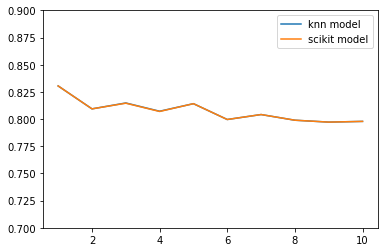

In [49]:
k_values = range(1, 11)
compare_models(X, y, k_values, use_kdtree=False)

LOO for with k=1


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=2


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=3


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=4


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=5


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=6


 [Elapsed Time: 0:00:29] 100%|###############################| (Time: 0:00:29) 


LOO for with k=7


 [Elapsed Time: 0:00:29] 100%|###############################| (Time: 0:00:29) 


LOO for with k=8


 [Elapsed Time: 0:00:29] 100%|###############################| (Time: 0:00:29) 


LOO for with k=9


 [Elapsed Time: 0:00:28] 100%|###############################| (Time: 0:00:28) 


LOO for with k=10


 [Elapsed Time: 0:00:29] 100%|###############################| (Time: 0:00:29) 


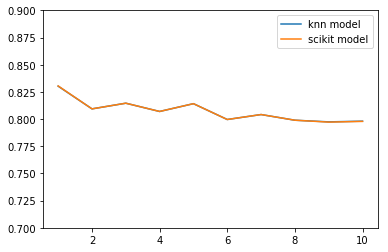

In [33]:
k_values = range(1, 11)
compare_models(X, y, k_values, use_kdtree=True)

LOO for with k=1


 [Elapsed Time: 0:01:21] 100%|###############################| (Time: 0:01:21) 


LOO for with k=2


 [Elapsed Time: 0:01:22] 100%|###############################| (Time: 0:01:22) 


LOO for with k=3


 [Elapsed Time: 0:01:20] 100%|###############################| (Time: 0:01:20) 


LOO for with k=4


 [Elapsed Time: 0:01:22] 100%|###############################| (Time: 0:01:22) 


LOO for with k=5


 [Elapsed Time: 0:01:22] 100%|###############################| (Time: 0:01:22) 


LOO for with k=6


 [Elapsed Time: 0:01:24] 100%|###############################| (Time: 0:01:24) 


LOO for with k=7


 [Elapsed Time: 0:01:23] 100%|###############################| (Time: 0:01:23) 


LOO for with k=8


 [Elapsed Time: 0:01:24] 100%|###############################| (Time: 0:01:24) 


LOO for with k=9


 [Elapsed Time: 0:01:25] 100%|###############################| (Time: 0:01:25) 


LOO for with k=10


 [Elapsed Time: 0:01:24] 100%|###############################| (Time: 0:01:24) 


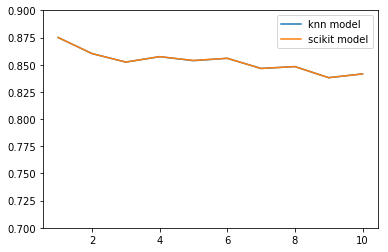

In [34]:
compare_models(normalize(X), y, k_values, use_kdtree=True)

In [42]:
def find_radius(X, y, lower, upper, eps):
    l = float(lower)
    r = float(upper)
    
    loo_res = list()
    best_res = 0.
    best_r = 0.
    
    while r - l > eps:
        m_l = l + (r-l)/3
        m_r = r - (r-l)/2
        
        m_l_res = leave_one_out(RNN_model(m_l, use_kdtree=True), X, y)        
        m_r_res = leave_one_out(RNN_model(m_r, use_kdtree=True), X, y)
        
        loo_res.append((m_l, m_l_res))
        loo_res.append((m_r, m_r_res))
        
#         print (m_l, m_l_res)
#         print (m_r, m_r_res)

        if m_l_res > m_r_res:
            best_res = m_r_res
            best_r = m_r
            l = m_l
        else:
            best_res = m_l_res
            best_r = m_l
            r = m_r
    
    loo_res = sorted(loo_res, key=lambda x:x[0])
    plt.plot([v[0] for v in loo_res], [v[1] for v in loo_res])
    
    return best_r, best_res

 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:29] 100%|###############################| (Time: 0:00:29) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:30] 100%|###############################| (Time: 0:00:30) 
 [Elapsed Time: 0:00:29] 100%|##########

14.3118427069 0.716583351445


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


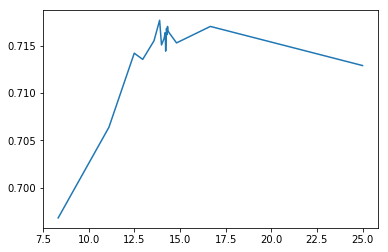

In [47]:
best_radius, accuracy = find_radius(X, y, 0., 50., eps=0.05)
print best_radius, accuracy

 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 
 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 
 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 
 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 
 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 
 [Elapsed Time: 0:01:31] 100%|##########

0.497416666667 0.606607259291


 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 


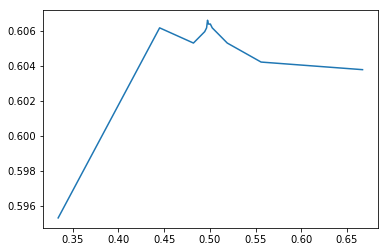

In [48]:
best_radius, accuracy = find_radius(normalize(X), y, 0.001, 1., eps=0.005)
print best_radius, accuracy